In [3]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models

import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

import os, sys
import json

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

#from torchvision import prototype as P

In [52]:
weights18  = 'IMAGENET1K_V1'
weights152 = 'IMAGENET1K_V1'


modelv1 = models.resnet18(weights=weights18)
modelv1 = modelv1.eval()

modelv2 = models.resnet152(weights=weights152)
modelv2 = modelv2.eval()



TypeError: __init__() got an unexpected keyword argument 'weights'

In [53]:
modelv1 = models.resnet18(pretrained=True)
modelv1 = modelv1.eval()

modelv2 = models.resnet152(pretrained=True)
modelv2 = modelv2.eval()

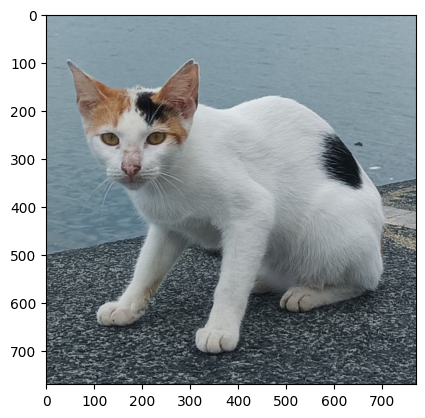

In [54]:
test_img = Image.open('C:\\Users\\asunc\\Downloads\\pythoncode\\dataset\\img\\cat.jpg')
test_img_data = np.asarray(test_img)
plt.imshow(test_img_data)
plt.show()


In [55]:
# model expects 224x224 3-color image
transform = transforms.Compose([
 transforms.Resize(224),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

# standard ImageNet normalization
transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

transformed_img = transform(test_img)
input_img = transform_normalize(transformed_img)
input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

labels_path = 'C:\\Users\\asunc\\Downloads\\pythoncode\\dataset\\img\\imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)


In [56]:
output = modelv1(input_img)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')



output = modelv2(input_img)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: Egyptian_cat ( 0.10097736120223999 )
Predicted: Egyptian_cat ( 0.5947815179824829 )


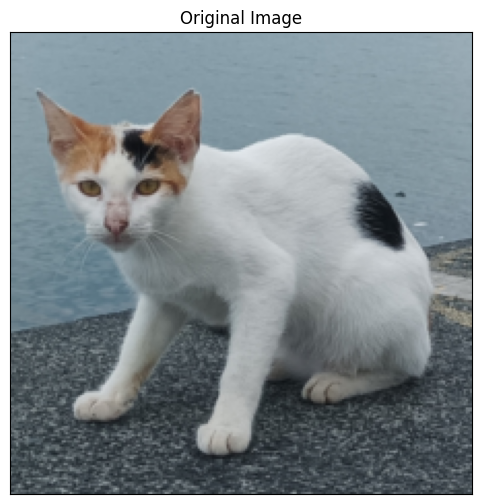

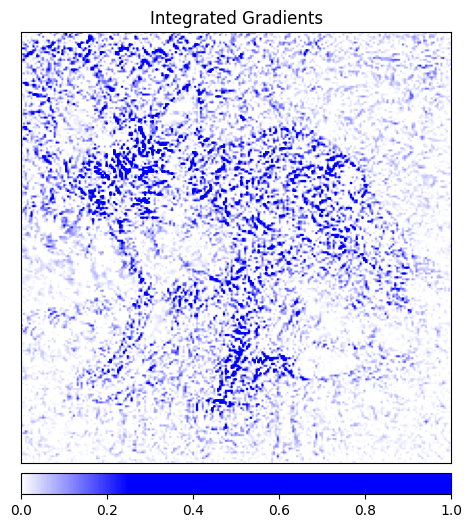

In [ ]:
# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(modelv1)

# Ask the algorithm to attribute our output target to
attributions_ig = integrated_gradients.attribute(input_img, target=pred_label_idx, n_steps=200)

# Show the original image for comparison
_ = viz.visualize_image_attr(None, np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                      method="original_image", title="Original Image")

default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients')



# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(modelv2)

# Ask the algorithm to attribute our output target to
attributions_ig = integrated_gradients.attribute(input_img, target=pred_label_idx, n_steps=200)

# Show the original image for comparison
_ = viz.visualize_image_attr(None, np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                      method="original_image", title="Original Image")

default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients')

In [ ]:
occlusion = Occlusion(modelv1)

attributions_occ = occlusion.attribute(input_img,
                                       target=pred_label_idx,
                                       strides=(3, 8, 8),
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)


_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map", "heat_map", "masked_image"],
                                      ["all", "positive", "negative", "positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
                                      fig_size=(18, 6)
                                     )



occlusion = Occlusion(modelv2)

attributions_occ = occlusion.attribute(input_img,
                                       target=pred_label_idx,
                                       strides=(3, 8, 8),
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)


_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map", "heat_map", "masked_image"],
                                      ["all", "positive", "negative", "positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
                                      fig_size=(18, 6)
                                     )



In [ ]:
layer_gradcam = LayerGradCam(modelv1, modelv1.layer3[1].conv2)
attributions_lgc = layer_gradcam.attribute(input_img, target=pred_label_idx)

_ = viz.visualize_image_attr(attributions_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                             sign="all",
                             title="Layer 3 Block 1 Conv 2")





layer_gradcam = LayerGradCam(modelv2, modelv2.layer3[1].conv2)
attributions_lgc = layer_gradcam.attribute(input_img, target=pred_label_idx)

_ = viz.visualize_image_attr(attributions_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                             sign="all",
                             title="Layer 3 Block 1 Conv 2")


In [ ]:
upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, input_img.shape[2:])

print(attributions_lgc.shape)
print(upsamp_attr_lgc.shape)
print(input_img.shape)

_ = viz.visualize_image_attr_multiple(upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                                      transformed_img.permute(1,2,0).numpy(),
                                      ["original_image","blended_heat_map","masked_image"],
                                      ["all","positive","positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Masked"],
                                      fig_size=(18, 6))


In [ ]:
imgs = ['C:\\Users\\asunc\\Downloads\\pythoncode\\dataset\\img\\cat.jpg', 
        'C:\\Users\\asunc\\Downloads\\pythoncode\\dataset\\img\\flower.jpg',
        'C:\\Users\\asunc\\Downloads\\pythoncode\\dataset\\img\\banana.jpg']

for img in imgs:
    img = Image.open(img)
    transformed_img = transform(img)
    input_img = transform_normalize(transformed_img)
    input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

    output = modelv1(input_img)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label_idx.squeeze_()
    predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
    print('Predicted:', predicted_label, '/', pred_label_idx.item(), ' (', prediction_score.squeeze().item(), ')')

    
    
imgs = ['C:\\Users\\asunc\\Downloads\\pythoncode\\dataset\\img\\cat.jpg', 
        'C:\\Users\\asunc\\Downloads\\pythoncode\\dataset\\img\\flower.jpg',
        'C:\\Users\\asunc\\Downloads\\pythoncode\\dataset\\img\\banana.jpg']

for img in imgs:
    img = Image.open(img)
    transformed_img = transform(img)
    input_img = transform_normalize(transformed_img)
    input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

    output = modelv2(input_img)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label_idx.squeeze_()
    predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
    print('Predicted:', predicted_label, '/', pred_label_idx.item(), ' (', prediction_score.squeeze().item(), ')')
    

In [ ]:
from captum.insights import AttributionVisualizer, Batch
from captum.insights.attr_vis.features import ImageFeature

# Baseline is all-zeros input - this may differ depending on your data
def baseline_func(input):
    return input * 0

# merging our image transforms from above
def full_img_transform(input):
    i = Image.open(input)
    i = transform(i)
    i = transform_normalize(i)
    i = i.unsqueeze(0)
    return i


input_imgs = torch.cat(list(map(lambda i: full_img_transform(i), imgs)), 0)

visualizer = AttributionVisualizer(
    models=[modelv1],
    score_func=lambda o: torch.nn.functional.softmax(o, 1),
    classes=list(map(lambda k: idx_to_labels[k][1], idx_to_labels.keys())),
    features=[
        ImageFeature(
            "Photo",
            baseline_transforms=[baseline_func],
            input_transforms=[],
        )
    ],
    dataset=[Batch(input_imgs, labels=[282,849,69])]
)


In [48]:
visualizer.render()


CaptumInsights(insights_config={'classes': ['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhe…

Output()

In [ ]:
from flask import Flask
app = Flask(__name__)


@app.route('/')
def hello():
    return 'Hello World!'


In [50]:
from torchvision.models import resnet50, ResNet50_Weights

# Old weights with accuracy 76.130%
resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# New weights with accuracy 80.858%
resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# Best available weights (currently alias for IMAGENET1K_V2)
# Note that these weights may change across versions
resnet50(weights=ResNet50_Weights.DEFAULT)

# Strings are also supported
resnet50(weights="IMAGENET1K_V2")

# No weights - random initialization
resnet50(weights=None)

ImportError: cannot import name 'ResNet50_Weights' from 'torchvision.models' (C:\Users\asunc\AppData\Roaming\Python\Python39\site-packages\torchvision\models\__init__.py)

In [49]:
from torchvision.models import resnet50, ResNet50_Weights

# Old weights with accuracy 76.130%
resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# New weights with accuracy 80.858%
resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# Best available weights (currently alias for IMAGENET1K_V2)
# Note that these weights may change across versions
resnet50(weights=ResNet50_Weights.DEFAULT)

# Strings are also supported
resnet50(weights="IMAGENET1K_V2")

# No weights - random initialization
resnet50(weights=None)

ImportError: cannot import name 'R3D_18_Weights' from 'torchvision.models.video' (C:\Users\asunc\AppData\Roaming\Python\Python39\site-packages\torchvision\models\video\__init__.py)

In [7]:
from torchvision.models import resnet

In [8]:
# Initialize the Weight Transforms
weights = ResNet50_Weights.DEFAULT
preprocess = weights.transforms()

# Apply it to the input image
img_transformed = preprocess(img)

NameError: name 'ResNet50_Weights' is not defined

In [5]:
print(torch.__version__)

2.0.1+cpu


In [9]:
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.hub import load_state_dict_from_url

__all__ = ['SqueezeNet', 'squeezenet1_0', 'squeezenet1_1']
model_urls = {
    'squeezenet1_0': 'https://download.pytorch.org/models/squeezenet1_0-a815701f.pth',
    'squeezenet1_1': 'https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth',
}

class Fire(nn.Module): #Fire模块
    def __init__(self, inplanes, squeeze_planes, expand1x1_planes, expand3x3_planes):

        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes, kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes, kernel_size=3, padding=1)
        self.expand3x3_activation = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.squeeze(x)
        x = self.squeeze_activation(x)
        return torch.cat([
            self.expand1x1_activation(self.expand1x1(x)),
            self.expand3x3_activation(self.expand3x3(x))
        ], 1)

class SqueezeNet(nn.Module):

    def __init__(self, version='1.0', num_classes=1000):
        super(SqueezeNet, self).__init__()
        self.num_classes = num_classes
        if version == '1_0':
            self.features = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=7, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(96, 16, 64, 64),
                Fire(128, 16, 64, 64),
                Fire(128, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 32, 128, 128),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                nn.MaxPool2d(kernel_size=3, stride=2 ,ceil_mode=True),
                Fire(512, 64, 256, 256),
            )
        elif version == '1_1':
            self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(64, 16, 64, 64),
                Fire(128, 16, 64, 64),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(128, 32, 128, 128),
                Fire(256, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                Fire(512, 64, 256, 256),
            )
        else:
            raise ValueError("Unsupported SqueezeNet version {version}: 1_0 or 1_1 expected".format(version=version))
        #使用卷积代替全连接层
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            final_conv,
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1,1))
        )
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.view(x.size(0), self.num_classes)

def _squeezenet(version, pretrained, progress, **kwargs):
    model = SqueezeNet(version, **kwargs)
    if pretrained:
        arch = 'squeezenet' + version
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

def squeezenet1_0(pretrained=False, progress=True, **kwargs):
    return _squeezenet('1_0', pretrained, progress, **kwargs)

def squeezenet1_1(pretrained=False, progress=True, **kwargs):
    return _squeezenet('1_1', pretrained, progress, **kwargs)


In [10]:
import IPython
import matplotlib
import matplotlib.pyplot as plt

In [16]:
import torch
import torchaudio

matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

torch.random.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(torchaudio.__version__)
print(device)

OSError: [WinError 127] The specified procedure could not be found

In [14]:
symbols = "_-!'(),.:;? abcdefghijklmnopqrstuvwxyz"
look_up = {s: i for i, s in enumerate(symbols)}
symbols = set(symbols)


def text_to_sequence(text):
    text = text.lower()
    return [look_up[s] for s in text if s in symbols]


text = "Hello world! Text to speech!"
print(text_to_sequence(text))

[19, 16, 23, 23, 26, 11, 34, 26, 29, 23, 15, 2, 11, 31, 16, 35, 31, 11, 31, 26, 11, 30, 27, 16, 16, 14, 19, 2]


In [15]:
processor = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_text_processor()

text = "Hello world! Text to speech!"
processed, lengths = processor(text)

print(processed)
print(lengths)

NameError: name 'torchaudio' is not defined

In [1]:
from torchvision import models


In [2]:
dir(models)


['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

In [3]:
#create an instance fo the Alexnet class
alexnet = models.AlexNet()
#Alexnet() is function
#forward pass
#output = alexnet(input)


In [21]:
resnet = models.googlenet(pretrained = True)
#这段代码使用 PyTorch 深度学习框架中的 models 模块来加载预训练的 ResNet-101 模型，并将其存储在 resent 变量中。 
#ResNet-101 是一个经过预训练的卷积神经网络模型，它使用 ImageNet 数据集上的数百万张图像进行了训练，可以用于图像分类、目标检测等计算机视觉任务。
#pretrained=True 的参数意味着加载的是预训练的模型，而不是一个随机初始化的模型。


C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to C:\Users\asunc/.cache\torch\hub\checkpoints\googlenet-1378be20.pth
100%|█████████████████████████████████████████████████████████████████████████████| 49.7M/49.7M [00:09<00:00, 5.62MB/s]


In [9]:
print(resnet)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize(256), #image size 256*256
    transforms.CenterCrop(224),#crop image to 224*224,around the center
    transforms.ToTensor(),#transform image into a tensor
    transforms.Normalize(
    mean = [0.485,0.456,0.406],
    std = [0.229, 0.224,0.225]) #normolize RGB,define means and std
])


In [11]:
from PIL import Image
#Pillow, website

img= Image.open(r"C:\\Users\\asunc\\Downloads\\pythoncode\\dataset\\img\\cat.jpg")


In [12]:
print(img)


<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=770x770 at 0x1AE31200D00>


In [13]:
img_t = preprocess(img)


In [14]:
import torch
batch_t = torch.unsqueeze(img_t,0)


In [15]:
resnet.eval()
# 将模型设置为评估模式


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
out = resnet(batch_t)


In [17]:
print(out)


tensor([[-1.9420e+00, -1.9871e+00, -1.7237e+00, -2.6819e-02,  1.1829e+00,
         -8.8003e-01, -7.2132e-01, -3.2364e+00, -1.1922e+00, -1.6634e+00,
         -3.2996e+00, -2.2316e+00, -2.0871e+00, -2.1772e+00, -3.4198e+00,
         -2.0423e+00, -9.1395e-01, -1.5634e-02, -2.0177e-01, -2.6723e+00,
         -1.1192e+00, -2.2692e+00, -1.6140e+00, -1.3693e+00, -2.8192e+00,
         -3.8083e+00, -3.1519e+00, -2.0857e+00, -4.0120e+00, -2.8757e+00,
         -3.1485e+00, -3.0758e+00, -3.3233e+00, -1.7654e+00, -1.2504e+00,
         -1.2497e+00, -9.8275e-01, -8.1206e-01, -1.9761e+00, -2.8496e+00,
         -3.7236e+00, -2.0560e+00, -2.1948e+00, -3.0991e+00, -1.8674e+00,
         -3.8514e+00, -2.0699e+00, -3.4824e+00, -3.3745e+00, -3.4591e+00,
         -2.8010e+00,  6.0316e-01, -3.2973e-01, -8.4253e-01, -1.0971e+00,
         -2.8193e+00, -2.1280e+00, -1.7312e+00, -1.0630e+00, -1.2382e+00,
         -1.3336e+00, -2.3173e+00, -1.8155e+00, -1.3490e+00, -2.6772e+00,
         -1.7197e+00, -1.2667e-01, -1.

In [18]:
print("最大值：", out.max().item())
print("最小值：", out.min().item())
_, index = torch.max(out, 1)
print("最大值所代表的类别：", index.item())


最大值： 9.193253517150879
最小值： -4.90177583694458
最大值所代表的类别： 285
